# Importando classes

In [2]:
# Torch
import torch
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

# Avaliação de resultados
from sklearn.metrics import accuracy_score

# Rodando scripts modularizados
%run "../pyScripts/devFunctions.py"

# PIL
from PIL import Image

# Numpy
import numpy as np

# Definindo as variáveis

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)), # Alterando tamanho da imagem para 64 x 64
    transforms.Grayscale(1), # Transformando imagem em cinza
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)), # Normalizando imagem para apenas um canal ao invés de 3 -> (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
])

batch_size = 64
train_data = "../../../GeneralData/train"
test_data = "../../../GeneralData/test"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## TrainSet e TrainLoader

In [4]:
train_set = datasets.ImageFolder(root=train_data, transform=transform)
test_set = datasets.ImageFolder(root=test_data, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

## Mostrando as imagens do trainset

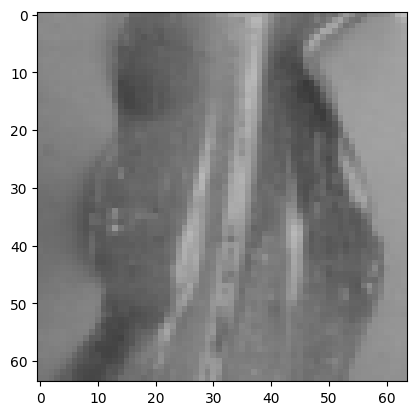

In [5]:
image = Image.open(test_set.imgs[3][0])
image_tensor = transform(image)

imshow(torchvision.utils.make_grid(image_tensor.unsqueeze(0)))

# Criando as classes

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # 64
        self.pool = nn.MaxPool2d(2, 2) # 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # 30
        self.fc1 = nn.Linear(64 * 15 * 15, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
Net = NeuralNetwork().to(DEVICE)

# Definindo o otimizador e a função de perda

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr=0.001, momentum=0.9)

# Treinando o modelo

In [8]:
for epoch in range(2):

    running_loss = 0.0

    for images, labels in train_loader:

        """
            Nesse caso, images é a representação em matriz da imagem.
            E labels é a representação de cada camada da CNN, se ela ativou ou não.
        """

        # Adquirindo entradas, "data" é uma lista [inputs, labels]
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # zerando os parâmetros dos gradientes
        optimizer.zero_grad()

        outputs = Net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f'[{epoch + 1}] loss: {running_loss / 2000:.3f}')

print("Treinamento concluído!")

[1] loss: 0.214
[2] loss: 0.142
Treinamento concluído!


# Avaliando o modelo

In [ ]:
Net.eval()
all_preds = []
all_labels = []

with torch.no_grad():  # Desativa o cálculo de gradientes para economizar memória
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = Net(images)
        _, predicted = torch.max(outputs, 1)  # Obtém a classe com maior probabilidade
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy of the model on the test set: {accuracy * 100:.2f}%")

Accuracy of the model on the test set: 78.72%


# Salvando Modelo

In [10]:
torch.save(Net.state_dict(), "./Models/generalAI_v1.pth")